In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

In [2]:
# function for seasonal mean (from Ian)
def season_mean(ds, calendar="standard"):
    #make a DataArray with the season of each day
    seas_array = ds.time.dt.season
    
    # count days in winter season (varies with leap years)
    nb_DJF = seas_array.str.count('DJF').sum()
    
    wgt_DJF = 1/nb_DJF.values.item()
    wgt_MAM = 1/(31+30+31)
    wgt_JJA = 1/(30+31+31)
    wgt_SON = 1/(30+31+30)

    weight = seas_array.str.replace('DJF',str(wgt_DJF)).str.replace('MAM',str(wgt_MAM)).str.replace('JJA',str(wgt_JJA)).str.replace('SON',str(wgt_SON))
    weight = weight.astype('float')
    
    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weight.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weight).groupby("time.season").sum(dim="time")

In [3]:
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}



In [4]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

In [6]:
ds_T_test_v314 = xr.open_dataset('/bettik/castelli/data/MAR3.14/MAR-ERA5/testrun_1month/ICE.ERA5.EUa.TTz.09.2014.nc')
ds_T_test_v314

<xarray.Dataset>
Dimensions:  (time: 30, ztqlev: 3, y: 126, x: 201)
Coordinates:
  * time     (time) datetime64[ns] 2014-09-01T12:00:00 ... 2014-09-30T12:00:00
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
  * ztqlev   (ztqlev) float32 2.0 10.0 100.0
Data variables:
    TTz      (time, ztqlev, y, x) float32 ...
Attributes:
    title:        ICE - Exp: a01 - 20140901
    institution:  ULg (Xavier Fettweis)
    history:      Fri Feb 16 11:43:08 2024: ncks -v TTz /bettik/castelli/MARo...
    netcdf:       4.8.0 of May  2 2023 12:43:48 $
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...

In [5]:
ds_T_normal = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.TTz.2014.nc')
ds_T_normal

<xarray.Dataset>
Dimensions:  (time: 365, ztqlev: 4, y: 126, x: 201)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01T12:00:00 ... 2014-12-31T12:00:00
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
  * ztqlev   (ztqlev) float32 2.0 10.0 50.0 100.0
Data variables:
    TTz      (time, ztqlev, y, x) float32 ...
Attributes:
    title:        ICE - Exp: l12 - 20140101
    institution:  ULg (Xavier Fettweis)
    history:      Thu May 14 23:59:20 2020: ncks -v TTz ICE.l12.2014.01.01-31...
    netcdf:       4.1.1 of Feb 12 2011 08:44:29 $
    NCO:          4.0.9

(10.0, 22.0)

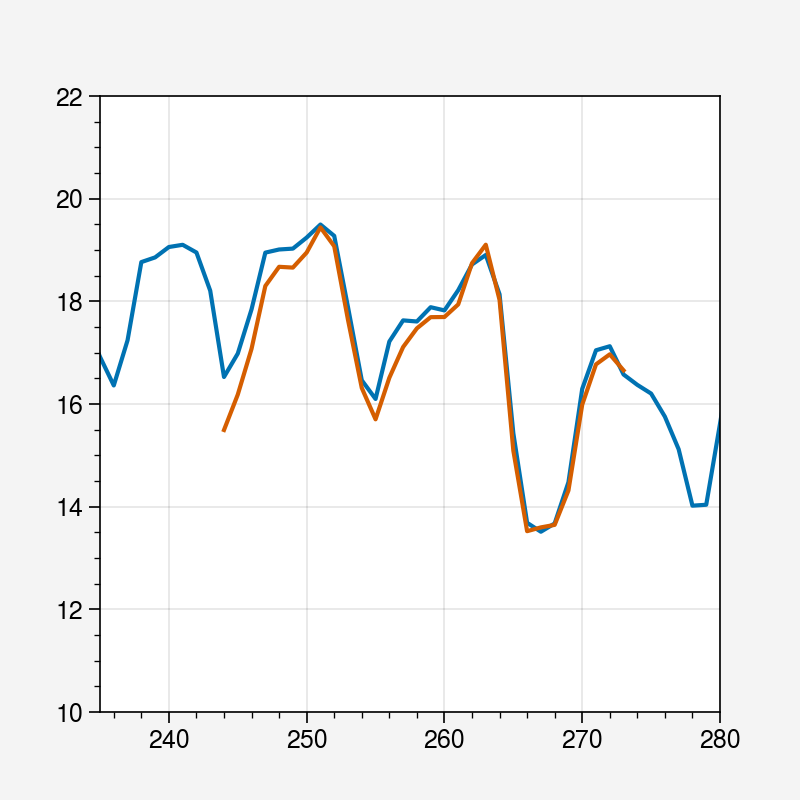

In [17]:
# 31+28+31+30+31+30+31+31 = 243 so 244 is first day of september

plt.plot(np.arange(1,366,1),ds_T_normal.TTz.isel(ztqlev=0).mean(axis=(1,2)))
plt.plot(np.arange(244,274,1),ds_T_test_v314.TTz.isel(ztqlev=0).mean(axis=(1,2)))
plt.xlim((235,280))
plt.ylim((10,22))

/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


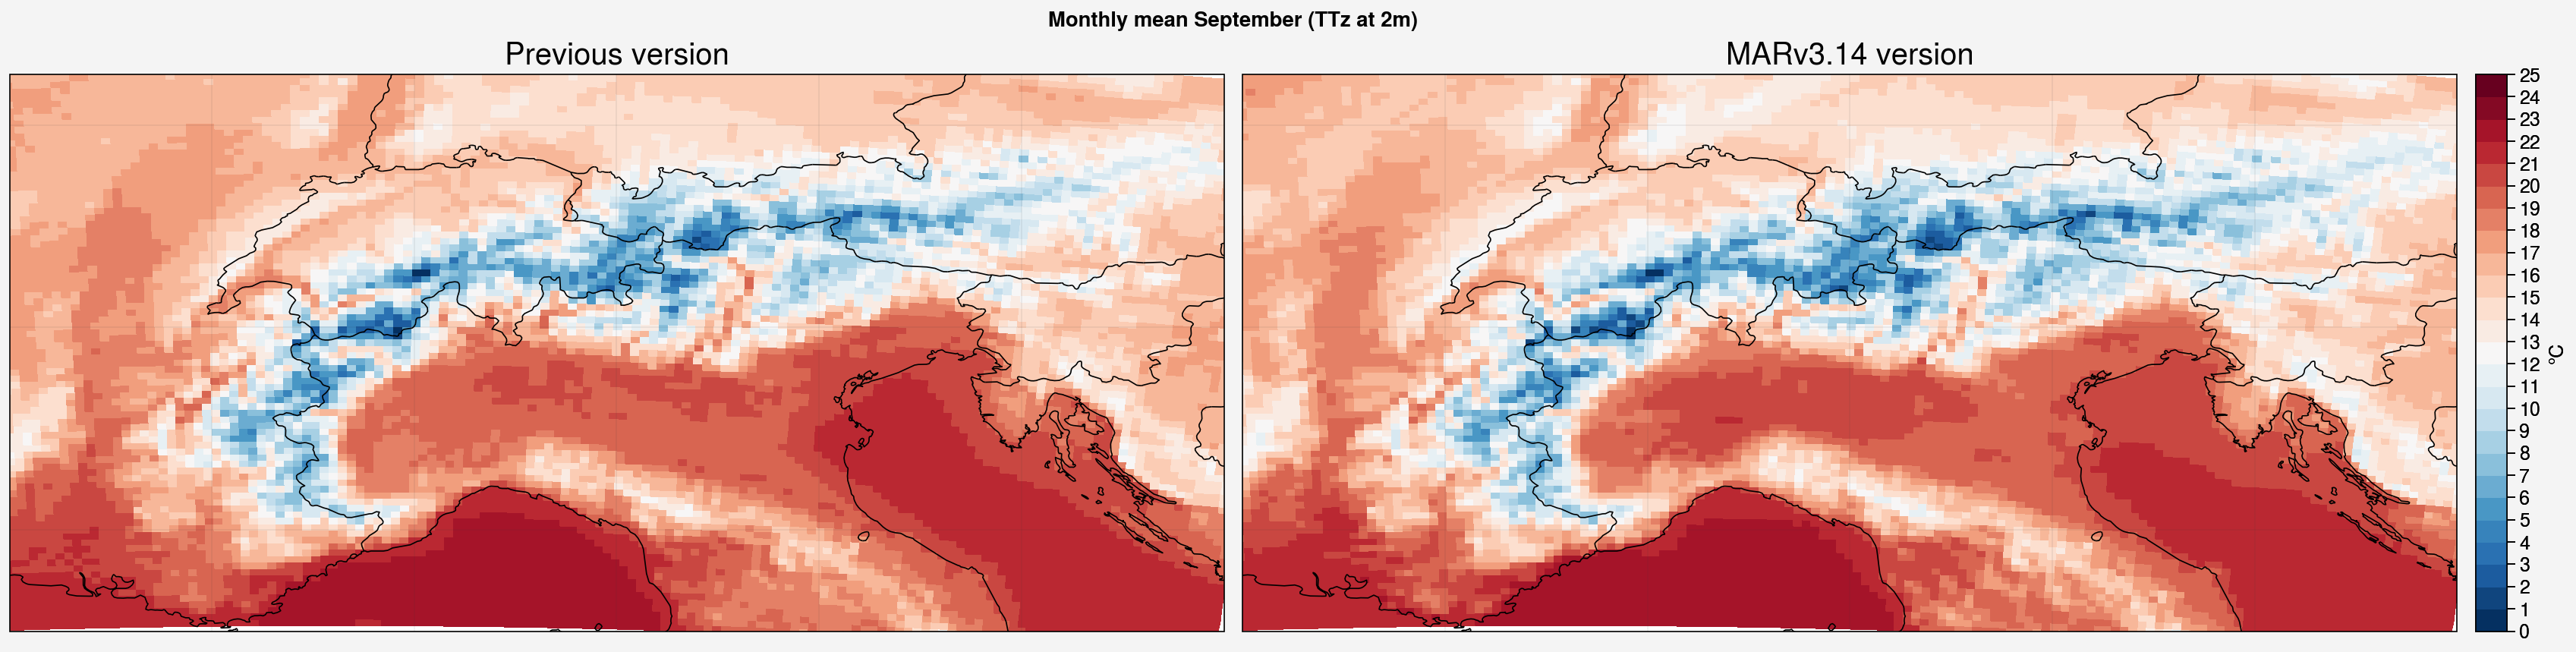

In [47]:
f, axs = pplt.subplots(proj='cyl',axwidth=8,ncols=2)


m = axs[0].pcolormesh(lon,lat,ds_T_normal.TTz.isel(ztqlev=0)[244:274,jmin:jmax,imin:imax].mean(axis=0),
                  levels=np.linspace(0,25,26),cmap='RdBu_r')
axs[0].format(title='Previous version',titlesize='20px')

m = axs[1].pcolormesh(lon,lat,ds_T_test_v314.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].mean(axis=0),
                  levels=np.linspace(0,25,26),cmap='RdBu_r')
axs[1].format(title='MARv3.14 version',titlesize='20px')
f.colorbar(m, label= '°C')

axs.format(**multiplot_format,suptitle="Monthly mean September (TTz at 2m)")

/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


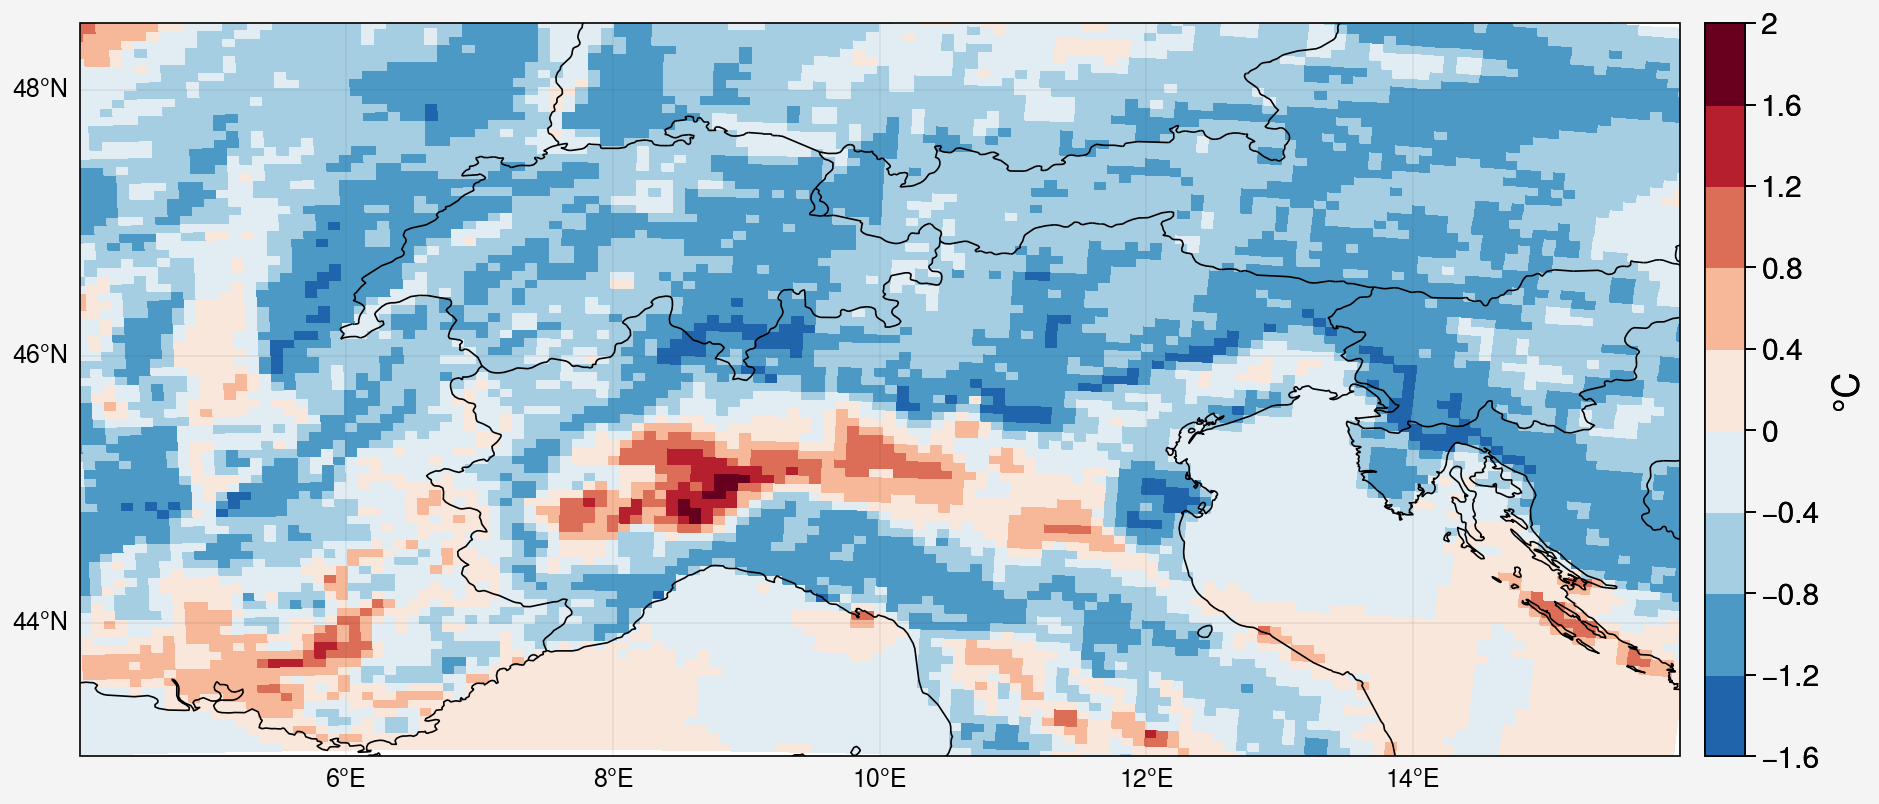

In [45]:
diff_2versions = np.array(ds_T_test_v314.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].
                          mean(axis=0)) - np.array(ds_T_normal.TTz.isel(ztqlev=0)[244:274,jmin:jmax,imin:imax].mean(axis=0))

f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(lon, lat, diff_2versions, levels=10,cmap='RdBu_r')
f.colorbar(m,label= '°C',labelsize='x-large',ticklabelsize='large')

ax.format(**normal_format)

#### Config b : January

In [6]:
ds_T_test_v314_Jan = xr.open_dataset('/bettik/castelli/data/MAR3.14/MAR-ERA5/testrun_1month/ICE.ERA5.EUb.TTz.01.2014.nc')
ds_T_test_v314_Jan

<xarray.Dataset>
Dimensions:  (time: 31, ztqlev: 3, y: 126, x: 201)
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01T12:00:00 ... 2014-01-31T12:00:00
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
  * ztqlev   (ztqlev) float32 2.0 10.0 100.0
Data variables:
    TTz      (time, ztqlev, y, x) float32 ...
Attributes:
    title:        ICE - Exp: b01 - 20140101
    institution:  ULg (Xavier Fettweis)
    history:      Wed Feb 21 15:08:51 2024: ncks -v TTz /bettik/castelli/MARo...
    netcdf:       4.8.0 of May  2 2023 12:43:48 $
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...

(0.0, 10.0)

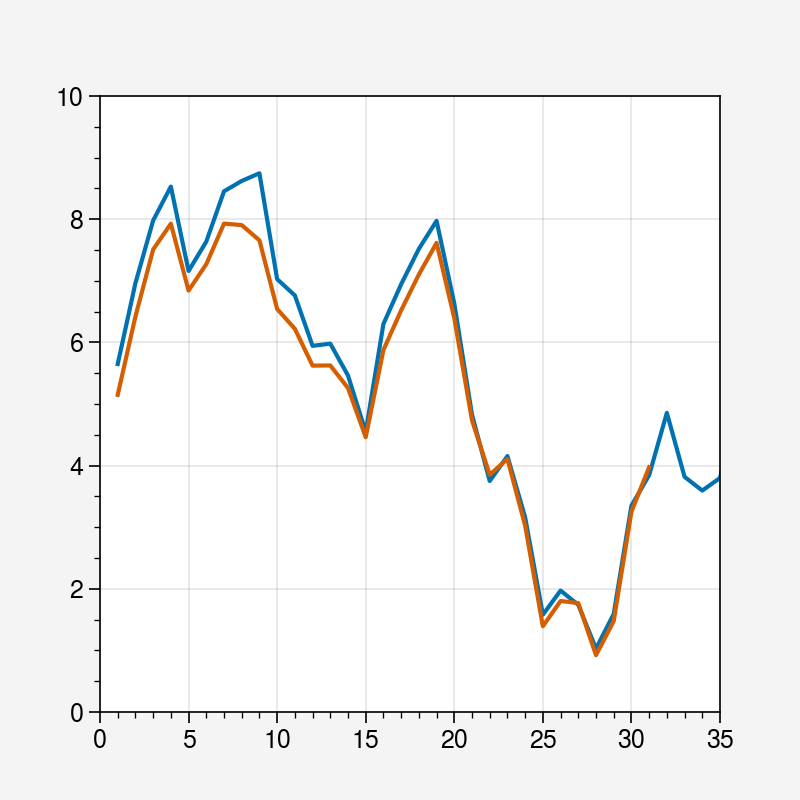

In [19]:
plt.plot(np.arange(1,366,1),ds_T_normal.TTz.isel(ztqlev=0).mean(axis=(1,2)))
plt.plot(np.arange(1,32,1),ds_T_test_v314_Jan.TTz.isel(ztqlev=0).mean(axis=(1,2)))
plt.xlim((0,35))
plt.ylim((0,10))
#plt.vlines(1,ymin=0,ymax=10)

/home/castelli/miniforge3/envs/phd_v1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


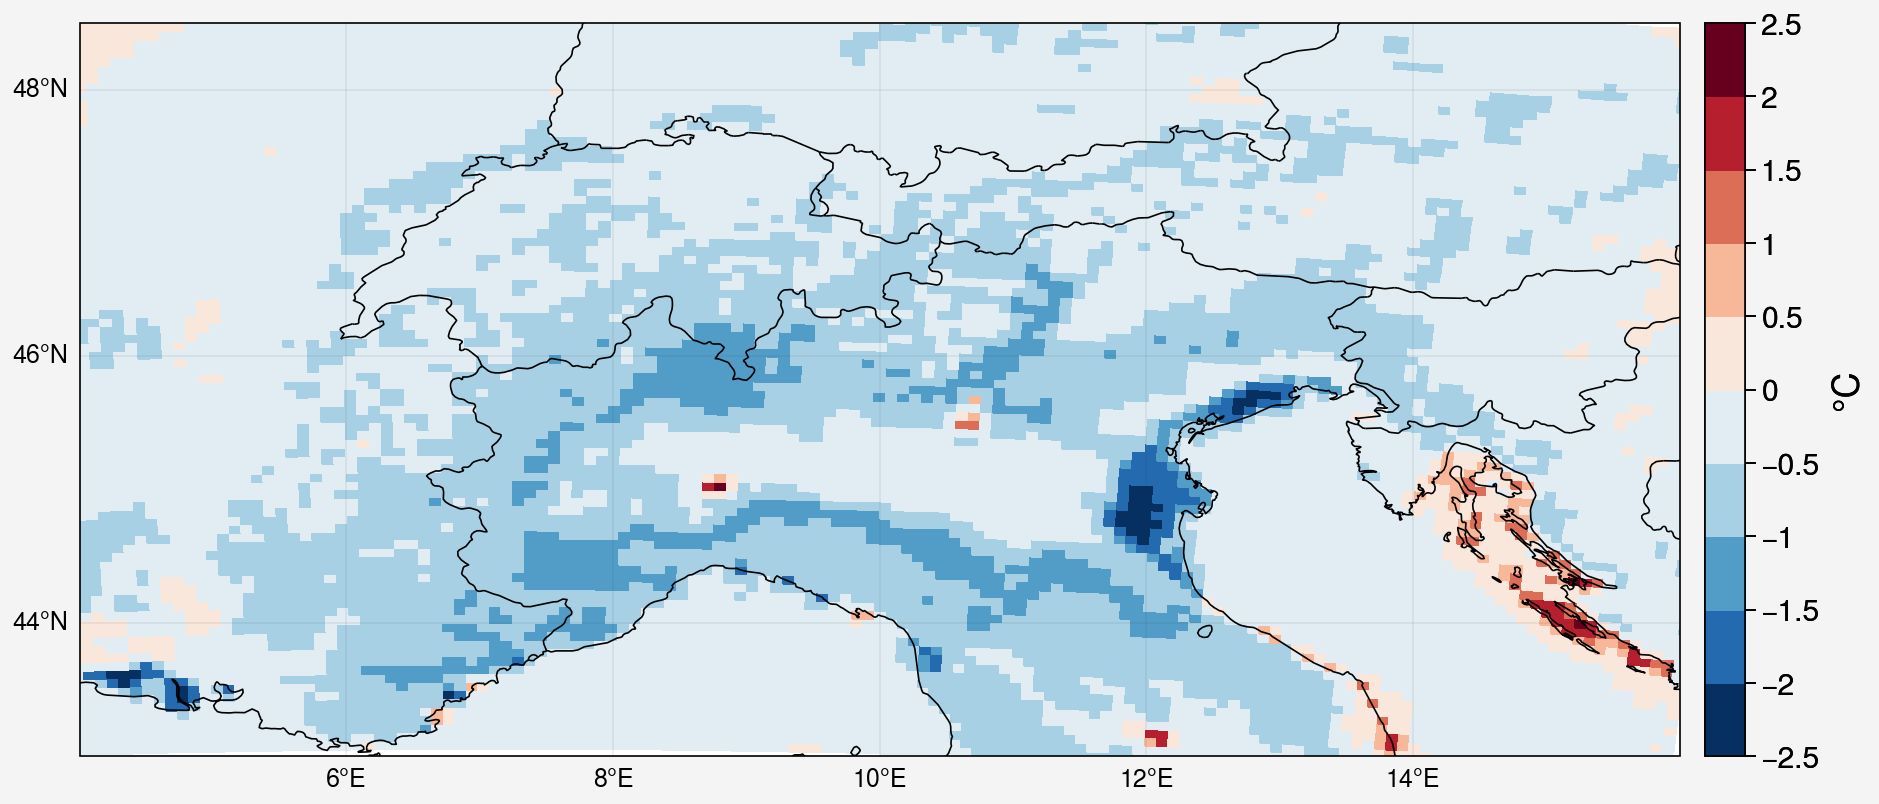

In [20]:
diff_2versions = np.array(ds_T_test_v314_Jan.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax].
                          mean(axis=0)) - np.array(ds_T_normal.TTz.isel(ztqlev=0)[0:31,jmin:jmax,imin:imax].mean(axis=0))

f, ax = pplt.subplots(proj='cyl', axwidth=8)
m=ax.pcolormesh(lon, lat, diff_2versions, levels=10,cmap='RdBu_r')
f.colorbar(m,label= '°C',labelsize='x-large',ticklabelsize='large')

ax.format(**normal_format)

In [22]:
diff_2versions.min()

-2.3039255